# Support Vector Machines en regresión

En este cuaderno modelizamos el porcentaje de voto de Vox en las elecciones de noviembre de 2019, mediante el algoritmo support vector machines en regresión.

Procederemos de manera similar a lo aplicado en otros cuadernos: definición de la columna, que es evidente en este caso, procesamiento de datasets train y test, y modelización.

## Definición de la columna objetivo

Comenzamos cargando las librerías necesarias y el dataset de noviembre de 2019.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [ ]:
strings = {'Sección' : 'str', 'cod_ccaa' : 'str', 'cod_prov' : 'str', 'cod_mun' : 'str'}

In [ ]:
import boto3

BUCKET_NAME = 'electomedia' 

# sustituir por credenciales de acceso. 
s3 = boto3.resource('s3', aws_access_key_id = 'xxxxxxxxxxxxxxx', 
                          aws_secret_access_key= 'xxxxxxxxxxxxxxxx')

In [ ]:
import botocore.exceptions

KEY = 'datos-elecciones-generales-unificados/gen_N19_unif_cols_prov_copia.txt' 

try:
    s3.Bucket(BUCKET_NAME).download_file(KEY, 'gen_N19_unif_cols_prov_copia.txt')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [ ]:
df_eleccion = pd.read_csv('gen_N19_unif_cols_prov_copia.txt', dtype = strings)

In [ ]:
df_eleccion

Sección  ...                                       dict_res_ord
0      022019111010400101001  ...  [('PSOE', 310), ('PP', 193), ('VOX', 122), ('C...
1      022019111010400201001  ...  [('PSOE', 349), ('VOX', 147), ('PP', 111), ('C...
2      022019111010400301001  ...  [('PP', 176), ('PSOE', 128), ('VOX', 116), ('U...
3      022019111010400301002  ...  [('VOX', 312), ('PP', 251), ('PSOE', 220), ('U...
4      022019111010400301003  ...  [('VOX', 327), ('PP', 292), ('PSOE', 202), ('C...
...                      ...  ...                                                ...
36297  022019111195200108011  ...  [('Otros', 348), ('PP', 303), ('VOX', 158), ('...
36298  022019111195200108012  ...  [('PP', 463), ('VOX', 210), ('PSOE', 205), ('O...
36299  022019111195200108013  ...  [('PP', 208), ('VOX', 144), ('PSOE', 113), ('O...
36300  022019111195200108014  ...  [('PP', 200), ('VOX', 126), ('PSOE', 87), ('Ot...
36301  022019111195200108015  ...  [('PP', 344), ('VOX', 209), ('PSOE', 199), ('O...

[36302 rows x 97 columns]

In [ ]:
df_eleccion.columns

Index(['Sección', 'cod_ccaa', 'cod_prov', 'cod_mun', 'cod_sec', 'CCAA',
       'Provincia', 'Municipio', 'Censo_Esc', 'Votos_Total', 'Participación',
       'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros', '% PP', '% PSOE', '% UP', '% Vox', '% Cs', '% IU',
       'Ganador', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayo

La variable objetivo es directamente una de las columnas, con lo que no tenemos ningún problema.

In [ ]:
df_eleccion['% Vox'].describe()

count    36299.000000
mean         0.149372
std          0.080258
min          0.000000
25%          0.088054
50%          0.149819
75%          0.201411
max          0.666667
Name: % Vox, dtype: float64

In [ ]:
df_eleccion['% Vox'].isna().sum()

3

In [ ]:
df_eleccion.loc[df_eleccion['% Vox'].isna()]

Sección  ...                                       dict_res_ord
4686   022019111014100701002  ...  [('PP', 0), ('PSOE', 0), ('Cs', 0), ('UP', 0),...
32884  022019111170301403031  ...  [('PP', 0), ('PSOE', 0), ('Cs', 0), ('UP', 0),...
32968  022019111170301406007  ...  [('PP', 0), ('PSOE', 0), ('Cs', 0), ('UP', 0),...

[3 rows x 97 columns]

Echamos un vistazo los porcentaje de votos de Vox, que supera el 30% en algunas secciones, aunque en bastantes de ellos el porcentaje es muy pequeño.

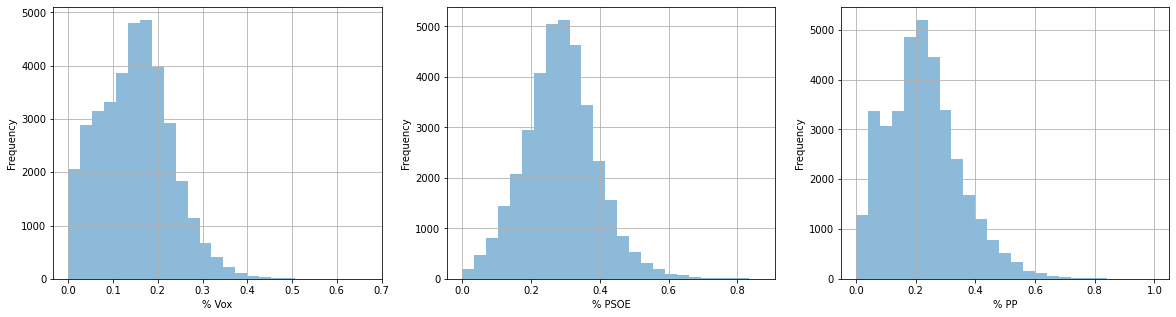

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
df_eleccion['% Vox'].plot.hist(alpha=0.5, bins=25, grid = True)
#plt.axis([0, 10, 0, 10000])
plt.xlabel('% Vox')

plt.subplot(1,3,2)
df_eleccion['% PSOE'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('% PSOE')

plt.subplot(1,3,3)
df_eleccion['% PP'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('% PP')

plt.show()

In [ ]:
df_eleccion['VOX'].sum()

3640377

In [ ]:
df_eleccion.describe()

cod_sec     Censo_Esc  ...  Renta Desempleo 2018  Renta Desempleo 2015
count  3.630200e+04  36302.000000  ...          34011.000000          34011.000000
mean   2.566980e+09    960.600353  ...            289.520129            346.385085
std    1.437009e+09    440.833524  ...            119.840778            118.286029
min    1.001010e+08      3.000000  ...             71.000000             81.000000
25%    1.103101e+09    692.000000  ...            216.000000            274.000000
50%    2.807904e+09    953.000000  ...            269.000000            335.000000
75%    3.727477e+09   1246.000000  ...            328.000000            393.000000
max    5.200108e+09   3848.000000  ...            846.000000            877.000000

[8 rows x 83 columns]

In [ ]:
df_eleccion.dtypes

Sección                  object
cod_ccaa                 object
cod_prov                 object
cod_mun                  object
cod_sec                   int64
                         ...   
Renta Pensiones 2015    float64
Renta Desempleo 2018    float64
Renta Desempleo 2015    float64
dict_res                 object
dict_res_ord             object
Length: 97, dtype: object

##Dataset de train

Y ya está, ya podemos pasar a separar train y test, y procesar ambos datasets, quedándonos en principio con el de train.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_eleccion, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('train_set_SVM_pc_VOX.txt', index=False)
test.to_csv('test_set_SVM_pc_VOX.txt', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

df_train = pd.read_csv('train_set_SVM_pc_VOX.txt',  dtype = strings)

Dimensiones del dataset de training: (29041, 97)
Dimensiones del dataset de test: (7261, 97)


In [ ]:
df_train

Sección  ...                                       dict_res_ord
0      022019111080501402001  ...  [('PSOE', 131), ('PP', 100), ('VOX', 56), ('UP...
1      022019111010401308001  ...  [('VOX', 179), ('PSOE', 160), ('PP', 97), ('UP...
2      022019111033304406014  ...  [('PSOE', 194), ('PP', 149), ('UP', 72), ('VOX...
3      022019111022206101003  ...  [('PP', 304), ('PSOE', 295), ('VOX', 166), ('U...
4      022019111084708101001  ...  [('PSOE', 14), ('PP', 8), ('UP', 4), ('VOX', 4...
...                      ...  ...                                                ...
29036  022019111092522201001  ...  [('JxC', 26), ('PP', 11), ('ERC', 11), ('CUP',...
29037  022019111153003006006  ...  [('PP', 142), ('VOX', 121), ('PSOE', 107), ('U...
29038  022019111144801601004  ...  [('PNV', 318), ('Bildu', 112), ('PSOE', 91), (...
29039  022019111094315504009  ...  [('ERC', 228), ('PSOE', 128), ('UP', 106), ('J...
29040  022019111012101002005  ...  [('PSOE', 353), ('VOX', 137), ('UP', 116), ('P...

[29041 rows x 97 columns]

In [ ]:
cols_iniciales = df_train.columns

In [ ]:
cols_iniciales

Index(['Sección', 'cod_ccaa', 'cod_prov', 'cod_mun', 'cod_sec', 'CCAA',
       'Provincia', 'Municipio', 'Censo_Esc', 'Votos_Total', 'Participación',
       'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros', '% PP', '% PSOE', '% UP', '% Vox', '% Cs', '% IU',
       'Ganador', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayo

Nos quedamos con las columnas socioeconómicas y elimnamos las de los votos y porcentajes a partidos, excepto la del porcentaje a Vox, que es nuestra columna objetivo.

In [ ]:
cols_validas = ['Provincia',
        'Censo_Esc', 'Participación',
        '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015', '% Vox']

In [ ]:
df_train = df_train[cols_validas]

In [ ]:
df_train

Provincia  Censo_Esc  ...  Renta Desempleo 2015     % Vox
0           Ávila        525  ...            296.000000  0.155125
1         Almería        798  ...            386.000000  0.338374
2        Asturias        846  ...            332.000000  0.128159
3          Huesca       1469  ...            185.000000  0.167339
4      Valladolid         39  ...            347.217589  0.125000
...           ...        ...  ...                   ...       ...
29036      Lérida         69  ...            347.217589  0.017241
29037      Murcia        714  ...            328.000000  0.242485
29038     Vizcaya       1032  ...                   NaN  0.018767
29039   Tarragona       1045  ...            326.000000  0.052126
29040      Huelva       1390  ...            599.000000  0.167892

[29041 rows x 48 columns]

In [ ]:
df_train.dtypes

Provincia                            object
Censo_Esc                             int64
Participación                       float64
0-4                                 float64
5-9                                 float64
10-14                               float64
15-19                               float64
20-24                               float64
25-29                               float64
30-34                               float64
35-39                               float64
40-44                               float64
45-49                               float64
50-54                               float64
55-59                               float64
60-64                               float64
65-69                               float64
70-74                               float64
75-79                               float64
80-84                               float64
85-89                               float64
90-94                               float64
95-99                           

In [ ]:
df_train.describe()

Censo_Esc  Participación  ...  Renta Desempleo 2015         % Vox
count  29041.000000   29041.000000  ...          27195.000000  29039.000000
mean     959.649186       0.700266  ...            346.347816      0.149245
std      440.799030       0.080533  ...            117.984770      0.080391
min        3.000000       0.000000  ...             81.000000      0.000000
25%      692.000000       0.655212  ...            274.000000      0.087801
50%      953.000000       0.706897  ...            335.000000      0.149671
75%     1245.000000       0.754367  ...            393.000000      0.201316
max     3848.000000       1.000000  ...            877.000000      0.666667

[8 rows x 47 columns]

No hay muchos valores nan, pero los existentes los cambiamos por la media de sus respectivas columnas.

In [ ]:
FillNA_num_mean = ['Censo_Esc', 'Participación',
        '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015']

In [ ]:
for item in FillNA_num_mean:
        
    df_train[item].fillna(df_train[item].mean(), inplace=True)

In [ ]:
df_train.describe()

Censo_Esc  Participación  ...  Renta Desempleo 2015         % Vox
count  29041.000000   29041.000000  ...          29041.000000  29039.000000
mean     959.649186       0.700266  ...            346.347816      0.149245
std      440.799030       0.080533  ...            114.173205      0.080391
min        3.000000       0.000000  ...             81.000000      0.000000
25%      692.000000       0.655212  ...            279.000000      0.087801
50%      953.000000       0.706897  ...            343.000000      0.149671
75%     1245.000000       0.754367  ...            387.000000      0.201316
max     3848.000000       1.000000  ...            877.000000      0.666667

[8 rows x 47 columns]

In [ ]:
categorical = ['Provincia']

In [ ]:
df_train['Provincia'].value_counts().sum()

29041

Ahora pasamos la variable categórica provincia a valor numérico mediante el método mean.

In [ ]:
mean_map1 = {}
for c in categorical:
    
    # df_filtered[c].fillna(df_filtered[c].mode()[0], inplace=True)
    
    mean = df_train.groupby(c)['% Vox'].mean()
    df_train[c] = df_train[c].map(mean)    
    mean_map1[c] = mean

In [ ]:
mean_map1

{'Provincia': Provincia
 Albacete                  0.201876
 Alicante                  0.191488
 Almería                   0.259946
 Asturias                  0.156009
 Badajoz                   0.166012
 Barcelona                 0.063776
 Burgos                    0.147633
 Cantabria                 0.146107
 Castellón                 0.179498
 Ceuta                     0.346349
 Ciudad Real               0.206865
 Cuenca                    0.176369
 Cáceres                   0.157472
 Cádiz                     0.210765
 Córdoba                   0.184431
 Gerona                    0.049217
 Gipúzcoa                  0.017890
 Granada                   0.203424
 Guadalajara               0.198673
 Huelva                    0.204458
 Huesca                    0.144476
 Islas Baleares            0.170612
 Jaén                      0.196352
 La Coruña                 0.080844
 La Rioja                  0.104578
 Las Palmas                0.132526
 León                      0.153572
 Lug

In [ ]:
df_train.dtypes

Provincia                           float64
Censo_Esc                             int64
Participación                       float64
0-4                                 float64
5-9                                 float64
10-14                               float64
15-19                               float64
20-24                               float64
25-29                               float64
30-34                               float64
35-39                               float64
40-44                               float64
45-49                               float64
50-54                               float64
55-59                               float64
60-64                               float64
65-69                               float64
70-74                               float64
75-79                               float64
80-84                               float64
85-89                               float64
90-94                               float64
95-99                           

In [ ]:
df_train.describe()

Provincia     Censo_Esc  ...  Renta Desempleo 2015         % Vox
count  29041.000000  29041.000000  ...          29041.000000  29039.000000
mean       0.149247    959.649186  ...            346.347816      0.149245
std        0.062640    440.799030  ...            114.173205      0.080391
min        0.017890      3.000000  ...             81.000000      0.000000
25%        0.080844    692.000000  ...            279.000000      0.087801
50%        0.175939    953.000000  ...            343.000000      0.149671
75%        0.182015   1245.000000  ...            387.000000      0.201316
max        0.346349   3848.000000  ...            877.000000      0.666667

[8 rows x 48 columns]

Podemos comprobar la correlación de las columnas entre sí, y vemos que las de sexo, rentas y edades tiene valores bastante altos. Como ocurre también entre la provincia y la variable objetivo.

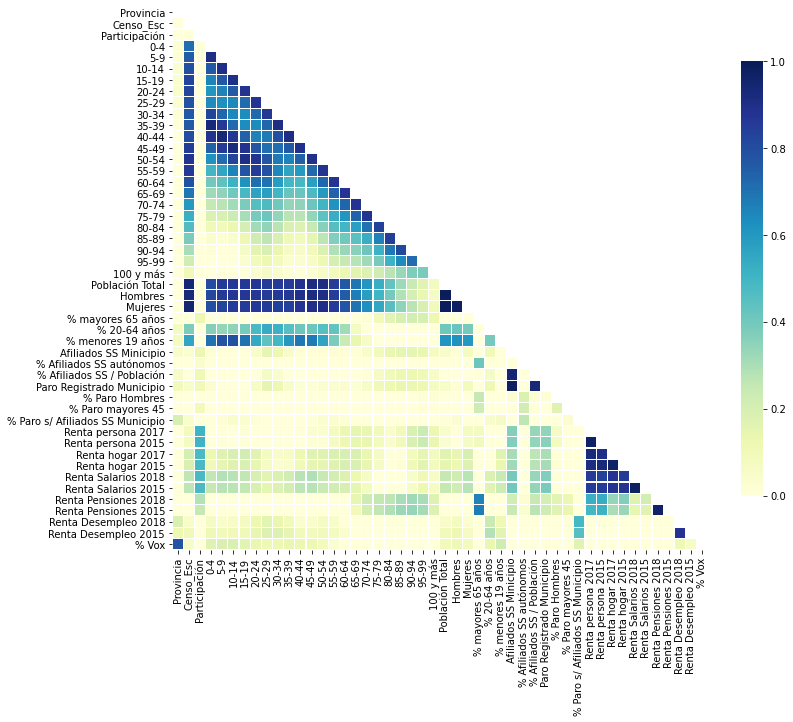

In [ ]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_train).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [ ]:
df_train.columns

Index(['Provincia', 'Censo_Esc', 'Participación', '0-4', '5-9', '10-14',
       '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
       '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94',
       '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015',
       '% Vox'],
      dtype='object')

Eliminamos una serie de columnas que estan demasiado correlacionadas con otras ya presentes en el dataset train.

In [ ]:
df_train = df_train.drop(['Renta persona 2015', 'Renta hogar 2015', 'Renta Salarios 2015', 'Renta Pensiones 2015', 'Renta Desempleo 2015', 'Hombres', 'Mujeres'], axis = 1)

In [ ]:
df_train

Provincia  Censo_Esc  ...  Renta Desempleo 2018     % Vox
0       0.171937        525  ...            347.000000  0.155125
1       0.259946        798  ...            391.000000  0.338374
2       0.156009        846  ...            174.000000  0.128159
3       0.144476       1469  ...            170.000000  0.167339
4       0.179048         39  ...            293.331625  0.125000
...          ...        ...  ...                   ...       ...
29036   0.038712         69  ...            293.331625  0.017241
29037   0.277958        714  ...            305.000000  0.242485
29038   0.023800       1032  ...            289.589405  0.018767
29039   0.075510       1045  ...            277.000000  0.052126
29040   0.204458       1390  ...            548.000000  0.167892

[29041 rows x 41 columns]

In [ ]:
df_train = df_train[df_train['% Vox'].notnull()]

In [ ]:
df_train.describe()

Provincia     Censo_Esc  ...  Renta Desempleo 2018         % Vox
count  29039.000000  29039.000000  ...          29039.000000  29039.000000
mean       0.149245    959.658390  ...            289.586243      0.149245
std        0.062641    440.812386  ...            115.752737      0.080391
min        0.017890      3.000000  ...             71.000000      0.000000
25%        0.080844    692.000000  ...            220.000000      0.087801
50%        0.175939    953.000000  ...            276.000000      0.149671
75%        0.182015   1245.000000  ...            322.000000      0.201316
max        0.346349   3848.000000  ...            846.000000      0.666667

[8 rows x 41 columns]

Y ahora ya podemos definir el vector 'y' y la matriz X del dataset de train.

In [ ]:
y_train = df_train['% Vox']

In [ ]:
y_train

0        0.155125
1        0.338374
2        0.128159
3        0.167339
4        0.125000
           ...   
29036    0.017241
29037    0.242485
29038    0.018767
29039    0.052126
29040    0.167892
Name: % Vox, Length: 29039, dtype: float64

In [ ]:
X_train = df_train.drop(['% Vox'], axis = 1)

In [ ]:
X_train.shape

(29039, 40)

In [ ]:
y_train.shape

(29039,)

##Dataset de test

Pasamos ahora al dataset de test, al que aplicaremos los mismos procedimientos y en el mismo orden que en el caso del de train.

In [ ]:
df_test = pd.read_csv('test_set_SVM_pc_VOX.txt',  dtype = strings)

In [ ]:
df_test

Sección  ...                                       dict_res_ord
0     022019111014105901016  ...  [('PP', 349), ('VOX', 248), ('PSOE', 164), ('C...
1     022019111122807403019  ...  [('PSOE', 308), ('PP', 200), ('UP', 170), ('VO...
2     022019111025025204001  ...  [('PSOE', 290), ('PP', 258), ('VOX', 178), ('C...
3     022019111090818703013  ...  [('PSOE', 194), ('UP', 112), ('VOX', 54), ('Cs...
4     022019111025029710083  ...  [('PSOE', 230), ('Cs', 122), ('PP', 106), ('UP...
...                     ...  ...                                                ...
7256  022019111053800801002  ...  [('PP', 314), ('PSOE', 301), ('CC', 248), ('UP...
7257  022019111071602901001  ...  [('PSOE', 22), ('PP', 19), ('VOX', 16), ('UP',...
7258  022019111111501901029  ...  [('PP', 279), ('PSOE', 277), ('BNG', 168), ('U...
7259  022019111011402503001  ...  [('PSOE', 427), ('UP', 315), ('PP', 83), ('Cs'...
7260  022019111091716501001  ...  [('JxC', 181), ('ERC', 136), ('CUP', 57), ('PS...

[7261 rows x 97 columns]

Seleccionamos las columnas que consideramos válidas...

In [ ]:
df_test = df_test[cols_validas]

...rellenamos los registros nan...

In [ ]:
for item in FillNA_num_mean:
        
    df_test[item].fillna(df_test[item].mean(), inplace=True)

In [ ]:
df_test.describe()

Censo_Esc  Participación  ...  Renta Desempleo 2015        % Vox
count  7261.000000    7261.000000  ...           7261.000000  7260.000000
mean    964.404627       0.700948  ...            346.533783     0.149883
std     440.981310       0.080442  ...            115.769128     0.079728
min       7.000000       0.000000  ...             81.000000     0.000000
25%     693.000000       0.657475  ...            279.000000     0.088698
50%     958.000000       0.707483  ...            343.000000     0.150205
75%    1253.000000       0.754395  ...            389.000000     0.201885
max    3085.000000       1.000000  ...            877.000000     0.489960

[8 rows x 47 columns]

In [ ]:
df_test.dtypes

Provincia                            object
Censo_Esc                             int64
Participación                       float64
0-4                                 float64
5-9                                 float64
10-14                               float64
15-19                               float64
20-24                               float64
25-29                               float64
30-34                               float64
35-39                               float64
40-44                               float64
45-49                               float64
50-54                               float64
55-59                               float64
60-64                               float64
65-69                               float64
70-74                               float64
75-79                               float64
80-84                               float64
85-89                               float64
90-94                               float64
95-99                           

...mapeamos la columna categórica, la provincia...

In [ ]:
for c in categorical:
    df_test[c] = df_test[c].map(mean_map1[c])

In [ ]:
df_test.dtypes

Provincia                           float64
Censo_Esc                             int64
Participación                       float64
0-4                                 float64
5-9                                 float64
10-14                               float64
15-19                               float64
20-24                               float64
25-29                               float64
30-34                               float64
35-39                               float64
40-44                               float64
45-49                               float64
50-54                               float64
55-59                               float64
60-64                               float64
65-69                               float64
70-74                               float64
75-79                               float64
80-84                               float64
85-89                               float64
90-94                               float64
95-99                           

In [ ]:
df_test['Provincia'].describe()

count    7261.000000
mean        0.149364
std         0.062763
min         0.017890
25%         0.080844
50%         0.175939
75%         0.182015
max         0.346349
Name: Provincia, dtype: float64

...eliminamos las columnas demasiado correlacionadas...

In [ ]:
df_test = df_test.drop(['Renta persona 2015', 'Renta hogar 2015', 'Renta Salarios 2015', 'Renta Pensiones 2015', 'Renta Desempleo 2015', 'Hombres', 'Mujeres'], axis = 1)

In [ ]:
df_test.shape

(7261, 41)

... y nos quedamos con las filas que tienen valores no nan en la columna objetivo.

In [ ]:
df_test = df_test[df_test['% Vox'].notnull()]

Con todo ello ya podemos definir el vector 'y' y la matriz X del dataset de test.

In [ ]:
y_test = df_test['% Vox']

In [ ]:
X_test = df_test.drop(['% Vox'], axis = 1)

In [ ]:
y_test.shape

(7260,)

In [ ]:
X_test.shape

(7260, 40)

In [ ]:
columnas = X_train.columns

In [ ]:
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

##Columnas más significativas

Pasamos a examinar cuáles son las columnas más significativas mediante la librería Mutual Info de SKlearn.

In [ ]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [ ]:
y_train

array([0.15512465, 0.33837429, 0.12815884, ..., 0.01876676, 0.0521262 ,
       0.16789216])

In [ ]:
y_test

array([0.24195122, 0.13723608, 0.20296465, ..., 0.10674157, 0.05353319,
       0.00796813])

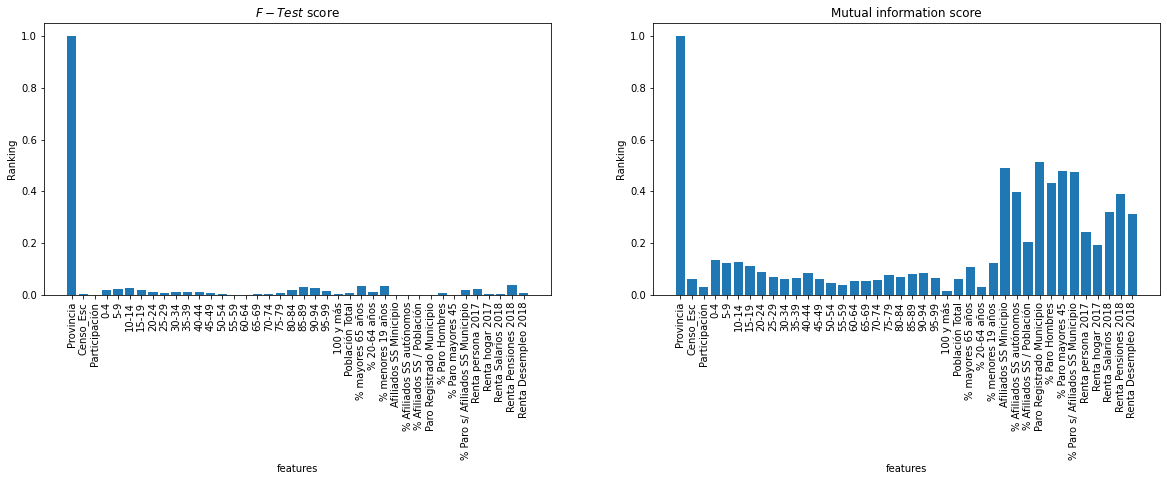

In [ ]:
y = y_train    # nos quedamos con la 1ª columna, price
X = X_train      # nos quedamos con el resto

feature_names = columnas


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

Vemos que la provincia es una columna muy importante, como intuíamos, además de las relacionadas con el paro y la afiliacion a la SS. La edad no parece ser un factor.

Nos quedamos con las 12 columnas más importantes.

In [ ]:
columnas_MI = columnas[mi > 0.2]

In [ ]:
columnas_MI

Index(['Provincia', 'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta Salarios 2018', 'Renta Pensiones 2018', 'Renta Desempleo 2018'],
      dtype='object')

In [ ]:
len(columnas_MI)

12

In [ ]:
X_train

array([[1.71937403e-01, 5.25000000e+02, 6.97142857e-01, ...,
        4.62900000e+03, 3.44300000e+03, 3.47000000e+02],
       [2.59945565e-01, 7.98000000e+02, 6.66666667e-01, ...,
        5.11500000e+03, 1.79900000e+03, 3.91000000e+02],
       [1.56008739e-01, 8.46000000e+02, 6.59574468e-01, ...,
        6.53600000e+03, 4.36900000e+03, 1.74000000e+02],
       ...,
       [2.37997778e-02, 1.03200000e+03, 7.26744186e-01, ...,
        8.32087064e+03, 3.17737358e+03, 2.89589405e+02],
       [7.55103085e-02, 1.04500000e+03, 7.01435407e-01, ...,
        9.43200000e+03, 2.20000000e+03, 2.77000000e+02],
       [2.04457535e-01, 1.39000000e+03, 5.97841727e-01, ...,
        5.56500000e+03, 1.96100000e+03, 5.48000000e+02]])

Reformulamos las matrices X de train y test ahora solo con las 12 columnas que consideramos más importantes.

In [ ]:
X_train = df_train[columnas_MI].values
X_test = df_test[columnas_MI].values

In [ ]:
X_train.shape

(29039, 12)

In [ ]:
X_test.shape

(7260, 12)

In [ ]:
np.log10(0.0005)

-3.3010299956639813

##Modelización con SVM en regresión

Ya podemos modelizar con support vector machines en regresión (SVR), y antes de ello debemos normalizar, al estar basado el modelo en distancias.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)
XtestScaled  = scaler.transform(X_test)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score

Hemos utilizado varias veces grid search, consumiendo bastante tiempo por cierto. Hemos encontrado que el hiperpámetro gamma no tiene una gran influencia en el score, pero C sí la tiene. Finalmente, tomamos un valor de gamma fijo, y hacemos un grid search con C.

In [ ]:
# Paso 2:
vectorC = np.logspace(1, 4, 6)
vectorG = np.logspace(-3.3, -3.3, 1)

param_grid = {'C': vectorC, 'gamma':vectorG}
grid = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid, cv = 3, verbose=5)
grid.fit(XtrainScaled, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=10.0, gamma=0.0005011872336272725 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=10.0, gamma=0.0005011872336272725, score=0.600, total=   2.1s
[CV] C=10.0, gamma=0.0005011872336272725 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] . C=10.0, gamma=0.0005011872336272725, score=0.599, total=   2.1s
[CV] C=10.0, gamma=0.0005011872336272725 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s


[CV] . C=10.0, gamma=0.0005011872336272725, score=0.602, total=   2.0s
[CV] C=39.810717055349734, gamma=0.0005011872336272725 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s


[CV]  C=39.810717055349734, gamma=0.0005011872336272725, score=0.604, total=   2.3s
[CV] C=39.810717055349734, gamma=0.0005011872336272725 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.5s remaining:    0.0s


[CV]  C=39.810717055349734, gamma=0.0005011872336272725, score=0.604, total=   2.7s
[CV] C=39.810717055349734, gamma=0.0005011872336272725 ...............
[CV]  C=39.810717055349734, gamma=0.0005011872336272725, score=0.605, total=   2.2s
[CV] C=158.48931924611142, gamma=0.0005011872336272725 ...............
[CV]  C=158.48931924611142, gamma=0.0005011872336272725, score=0.606, total=   3.8s
[CV] C=158.48931924611142, gamma=0.0005011872336272725 ...............
[CV]  C=158.48931924611142, gamma=0.0005011872336272725, score=0.600, total=   3.7s
[CV] C=158.48931924611142, gamma=0.0005011872336272725 ...............
[CV]  C=158.48931924611142, gamma=0.0005011872336272725, score=0.609, total=   3.7s
[CV] C=630.957344480193, gamma=0.0005011872336272725 .................
[CV]  C=630.957344480193, gamma=0.0005011872336272725, score=0.614, total=   7.9s
[CV] C=630.957344480193, gamma=0.0005011872336272725 .................
[CV]  C=630.957344480193, gamma=0.0005011872336272725, score=0.607, tota

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  5.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([   10.        ,    39.81071706,   158.48931925,   630.95734448,
        2511.88643151, 10000.        ]),
                         'gamma': array([0.00050119])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

Vemos gráficamente que encontramos el score más alto con un valor de C de 10.000 ...

best mean cross-validation score: 0.616
best parameters: {'C': 10000.0, 'gamma': 0.0005011872336272725}


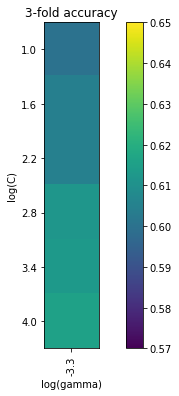

In [ ]:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.57, vmax=0.65)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('3-fold accuracy')
plt.show()

...por lo que hacemos el fit del modelo con este valor y el de gamma que ya conocíamos, obteniendo un score para test bastante aceptable de 0.64, muy similr al de train obtenido en el cross validation, con lo que no parece haber overfitting.

In [ ]:
# Paso 3:
Copt = grid.best_params_['C']
Gopt = grid.best_params_['gamma']

svmModel = SVR(kernel='rbf',gamma = Gopt, C = Copt).fit(XtrainScaled,y_train)
print('Acc (TEST): %0.2f'%svmModel.score(XtestScaled,y_test))

Acc (TEST): 0.64
